# Extract Trajectory from Video

In [1]:
from pathlib import Path
import os
from pytube import YouTube
import cv2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import matplotlib.animation as animation
from IPython.display import HTML


%run ../lib.py

In [2]:
def show_frame(frame):
    """Display a frame in the notebook"""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame using matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [3]:
# Download the videos, if necessary

vid_urls = [
    ('https://youtu.be/mzZrpmhBnkQ?feature=shared',  'basketball.mp4'),
    ('https://youtu.be/Iv3upkhSJ9U?feature=shared&t=9','canon.mp4'),
    ('', 'ball_trajectory.mp4') # video is generated
]

vids = []

for url, vfn in vid_urls:
    vf = vd/vfn
    if not vf.exists():
        yt = YouTube(url).streams.first()
        print("Download",  vfn)
        fp = yt.download(output_path=vd, filename=vfn)

    vids.append(vf)


In [4]:
def extract_traj(fp, centroid_func=None, ex_frame=.5):
    """Run extraction function and generate dataframe, for each frame in the movie"""
    # Open the video file
    cap = cv2.VideoCapture(fp)

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Iterate over the frames
    frame_count = 0
    rows = []
    frame_shown = False
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        if centroid_func:
            centroid, aframe = centroid_func(frame)
            rows.append({
                'x': centroid[0],
                'y': centroid[1]
            })
        else:
            aframe = frame
    
        if not frame_shown and frame_count > n_frames*ex_frame:
            
            show_frame(aframe)

            frame_shown = True
        
    cap.release()

    if rows:
        df = pd.DataFrame(rows)
        
        #t['x'] = t.x.max() - t.x
        df['y'] = df.y.max() - df.y
    
        return df

In [5]:
def find_cannonball_centroid_color(image):
    """Find the centroid for the canon ball in the canon video. """
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color range for the red cannonball
    # FIXME?> I think this should acrtually be a split range for red in  HSV
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([8, 255, 255])

    # Create a mask for the red color
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours found, handle the case
    if len(contours) == 0:
        return None, image

    # Assume the largest contour is the cannonball
    cannonball_contour = max(contours, key=cv2.contourArea)

    # Compute the centroid of the cannonball
    M = cv2.moments(cannonball_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    # Draw the contour and centroid on the image
    cv2.drawContours(image, [cannonball_contour], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 2, (255, 0, 0), -1)
   
    return (cX, cY), image

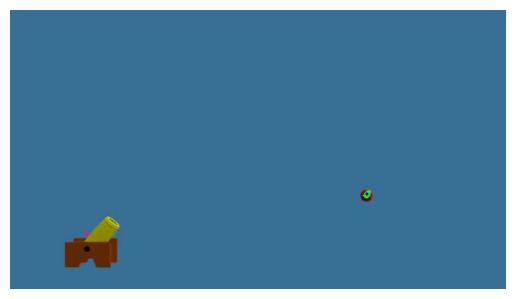

<Axes: xlabel='x'>

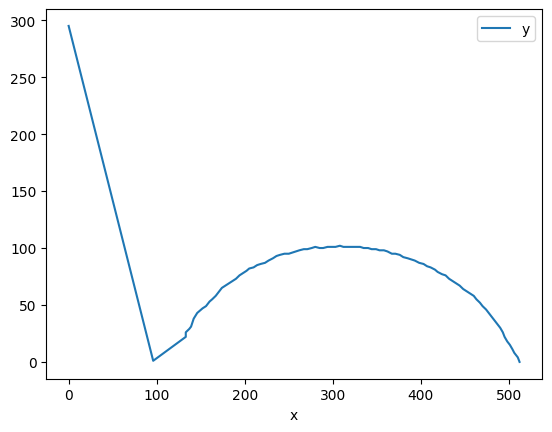

In [6]:
df = extract_traj(vids[1], find_cannonball_centroid_color, ex_frame=.5)

df.plot(x='x', y='y')

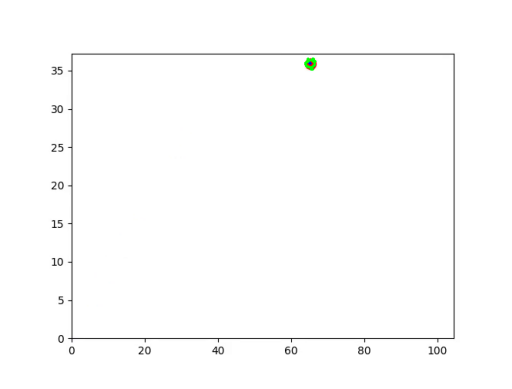

<Axes: xlabel='x'>

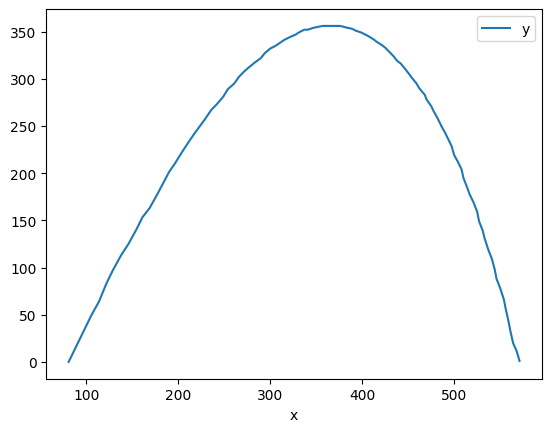

In [7]:
# Generated trajectory video, which also has a red ball

df = extract_traj(vids[2], find_cannonball_centroid_color, ex_frame=.5)

df.plot(x='x', y='y')

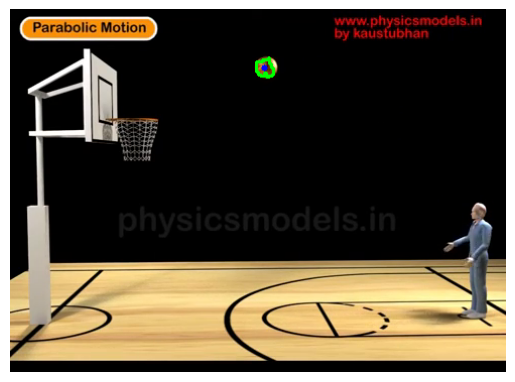

<Axes: xlabel='x'>

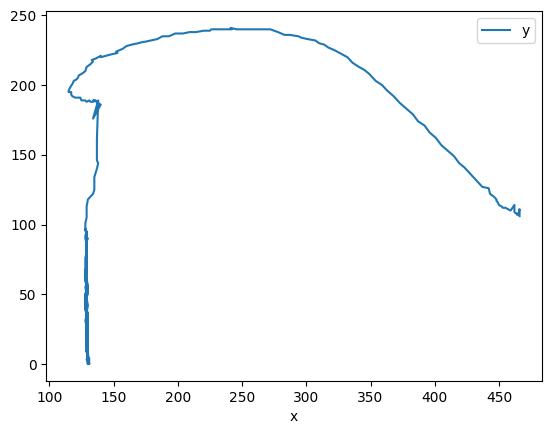

In [8]:
# Basketball video

def find_basketball_centroid(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color range for the basketball (shades of orange)
    lower_orange = np.array([5, 100, 100])
    upper_orange = np.array([15, 255, 255])

    # Create a mask for the orange color
    mask = cv2.inRange(hsv, lower_orange, upper_orange)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours found, handle the case
    if len(contours) == 0:
        return None, image

    # Assume the largest contour is the basketball
    basketball_contour = max(contours, key=cv2.contourArea)

    # Compute the centroid of the basketball
    M = cv2.moments(basketball_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    # Draw the contour and centroid on the image
    cv2.drawContours(image, [basketball_contour], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 3, (255, 0, 0), -1)

    return (cX, cY), image
    
df = extract_traj(vids[0], find_basketball_centroid, ex_frame=.2)

df.plot(x='x', y='y')

# Circle Finder

620


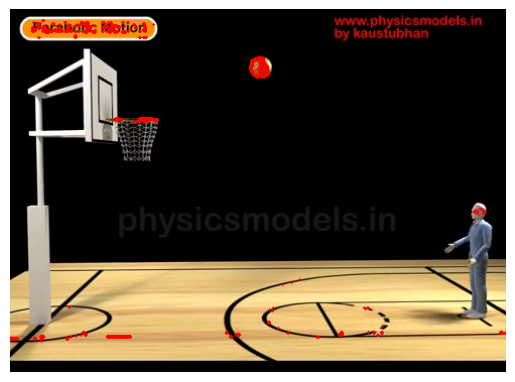

In [9]:

import cv2
import numpy as np

def find_circles_in_mask(mask, original_image):
    # Clone the original image to draw on
    output_image = original_image.copy()

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to hold all detected circles
    all_circles = []

    for contour in contours:
        # Draw the contour in red
        cv2.drawContours(output_image, [contour], -1, (0, 0, 255), 2)

        # Get the bounding rectangle of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Expand the region by 50%
        x_expanded = max(0, x - int(0.25 * w))
        y_expanded = max(0, y - int(0.25 * h))
        w_expanded = int(1.5 * w)
        h_expanded = int(1.5 * h)

        # Create a sub-mask for the expanded region
        sub_mask = mask[y_expanded:y_expanded + h_expanded, x_expanded:x_expanded + w_expanded]

        # Detect circles in the sub-mask using HoughCircles
        circles = cv2.HoughCircles(sub_mask, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0)
        
        if circles is not None:
            # Convert the circle parameters (x, y, radius) to integers
            circles = np.round(circles[0, :]).astype("int")

            for (cx, cy, r) in circles:
                # Adjust circle coordinates to the original mask's coordinate system
                cx += x_expanded
                cy += y_expanded
                all_circles.append((cx, cy, r))

                # Draw the circle in green
                cv2.circle(output_image, (cx, cy), r, (0, 255, 0), 2)
                cv2.rectangle(output_image, (cx - 5, cy - 5), (cx + 5, cy + 5), (0, 128, 255), -1)
    
    return all_circles, output_image


def extract_traj(fp, centroid_func=None, ex_frame=.5):
    """Run extraction function and generate dataframe, for each frame in the movie"""
    # Open the video file
    cap = cv2.VideoCapture(fp)

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(n_frames)
    
    # Iterate over the frames
    frame_count = 0
    rows = []
    frame_shown = False

    
    # Define color range for the basketball (shades of orange)
    lower_m = np.array([5, 100, 100])
    upper_m = np.array([15, 255, 255])

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
    
        if not frame_shown and frame_count > n_frames*ex_frame:

            # Create a mask for the red color
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, lower_m, upper_m)

            circles, aframe = find_circles_in_mask(mask, frame)
            
            frame_rgb = cv2.cvtColor(aframe, cv2.COLOR_BGR2RGB)
            
            # Display the frame using matplotlib
            plt.imshow(frame_rgb)
            plt.axis('off')  # Turn off axis numbers and ticks
            plt.show()

            frame_shown = True
        frame_count += 1
        
    cap.release()

  
df = extract_traj(vids[0], ex_frame=.2)



# Background subtraction


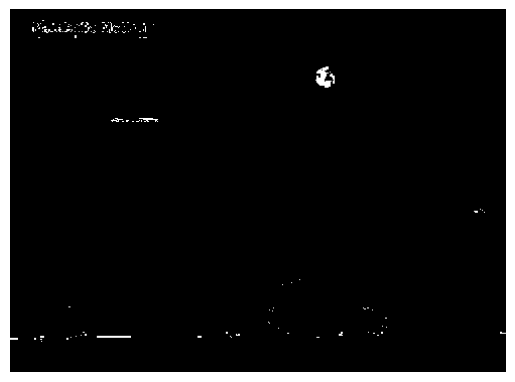

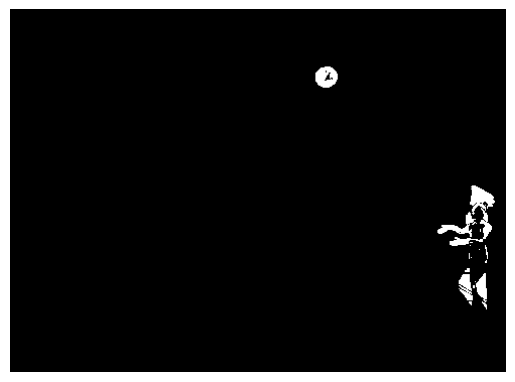

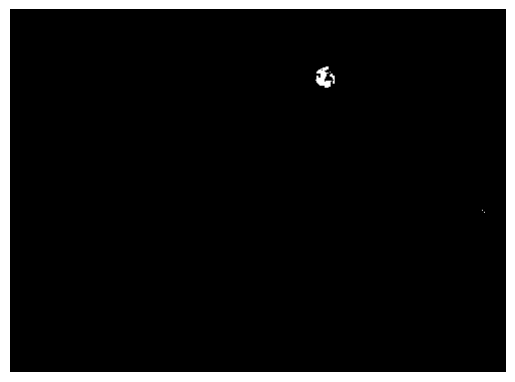

In [13]:

def calc_background(video_path, num_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []

    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)

    cap.release()
    median_frame = np.mean(frames, axis=0).astype(dtype=np.uint8)
    return median_frame
    
def sub_bg(video_path):
    background = calc_background(video_path)
    
    cap = cv2.VideoCapture(video_path)
    subtracted_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        mask = cv2.absdiff(gray, background)
        _, mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
        subtracted_frames.append(mask)

    cap.release()
    return subtracted_frames

def mask_color(video_path, lower_color, upper_color):
    cap = cv2.VideoCapture(video_path)
    masked_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert the frame to HSV color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Apply the color mask
        mask = cv2.inRange(hsv, lower_color, upper_color)
        masked_frame = cv2.bitwise_and(frame, frame, mask=mask)
        
        # Convert the masked frame to grayscale
        gray_masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
        
        # Threshold the grayscale masked frame to get a binary (1-bit) image
        _, binary_masked_frame = cv2.threshold(gray_masked_frame, 1, 255, cv2.THRESH_BINARY)
        
        # Append the binary masked frame to the list
        masked_frames.append(binary_masked_frame)

    cap.release()
    return masked_frames

# Define color range for the basketball (shades of orange)
lower_m = np.array([5, 100, 100])
upper_m = np.array([15, 255, 255])

c_frames = mask_color(vids[0], lower_m, upper_m)

nbg_frames = sub_bg(vids[0])

def and_frames(list1, list2):
    # Check if both lists have the same number of frames
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same number of frames.")
    
    anded_frames = []
    
    for frame1, frame2 in zip(list1, list2):
        # Perform bitwise AND operation
        anded_frame = cv2.bitwise_and(frame1, frame2)
        anded_frames.append(anded_frame)
    
    return anded_frames

frames = and_frames(c_frames, nbg_frames)

show_frame(c_frames[100])
show_frame(nbg_frames[100])
show_frame(frames[100])

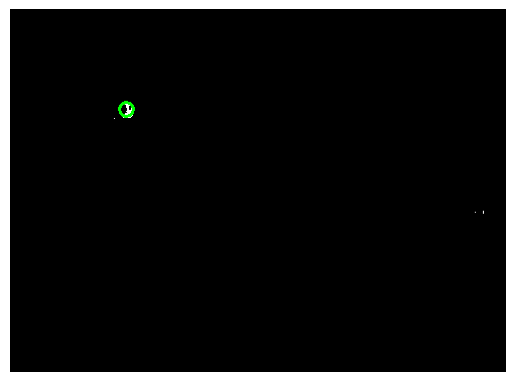

In [11]:

def find_circles(frames):
    centers = []
    updated_frames = []

    for frame in frames:
        # Find contours in the frame
        contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)

            # Find the minimum enclosing circle of the largest contour
            (x, y), radius = cv2.minEnclosingCircle(largest_contour)
            center = (int(x), int(y))
            radius = int(radius)

            # Draw the circle on the frame
            output_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)  # Convert to BGR for coloring
            cv2.circle(output_frame, center, radius, (0, 255, 0), 2)
            
            centers.append(center)
            updated_frames.append(output_frame)
        else:
            # If no contours are found, just add the original frame
            updated_frames.append(frame)
            centers.append((0, 0))

    return centers, updated_frames

c, c_frames = find_circles(frames)

show_frame(c_frames[200])

In [12]:

# This never seems to complete, just runs forever ... 
def animate_frames(frames, interval=100):
    fig, ax = plt.subplots()

    def update(frame):
        ax.imshow(frame, cmap='gray')
        return ax

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=interval, repeat=False)

    plt.close(fig)  # Prevents the initial frame from being displayed

    return HTML(ani.to_jshtml())

#animate_frames(c_frames)